# Dynamic Time Warping with Financial Time Series
In one of the ML books I was going through from Packt Publishing (I can't find which book it was), I saw a cool example of using dynamic time warping (DTW) for detecting the similarities of music tracks. Audio data is a type of time series. Comparing the distances between two time series at each point in time can provide a sense of whether the two series are more or less similar depending on the distance.

I wondered what would happen if I applied DTW to some basic financial time series and came up with some interesting visualization results.

#### Package Dependencies
We'll use a couple of Python packages that you may need to install: pandas_datareader and dtw.

Assuming you have the Python package installer configured for your environment, you can easily install the extra packages:

‘pip install pandas_datareader‘
‘pip install dtw‘

#### Import the packages
In a .py file or a Jupyter notebook, import the following:


In [16]:
from dtw import dtw
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import norm
from numpy import array
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

### Data Getter
This function loops through a list of ticker symbols and retrieves the time series data from Yahoo! Finance.

#### Inputs
The following function takes 3 inputs:
* A Python list of ticker symbols.
* Start Date in Python datetime format.
* End Date in Python datetime format.

#### Outputs
The function returns a Python dictionary containing time series data for each symbol. The keys to the dictionary are the symbols.

In [8]:
def get_data(symbols, start, end):
    start = start
    end = end
    ts = {} # Dictionary for holding the time series for each symbol.
    
    # Loop through the list of symbols:
    for s in symbols:
        try:
            # Get Data from Yahoo!
            ts[s] = web.DataReader(s, "yahoo", start, end)
        except:
            # Depending on my connection, sometimes there are hiccups pulling in data.
            # This is a simple workaround to ignore any time series that can't be downloaded.
            # More robust exception handling is needed for production scenarios.
            print("Issue with %s"%s)
    return ts

#### List of Ticker Symbols
Here is a list of some random symbols from different industries. Depending on your connection speed, it could take a while to download one year's data for a given symbol. On my home network one symbol's series only takes a couple of seconds while on a shared network the download can take as much as 10 seconds per symbol.

In [33]:
tickers = ['HD','PETM','AMZN','CAT','DIS','MCD','SBUX','MSFT','AAPL','DB']

# Set the start and end dates.
start = datetime.date(2017, 1, 1)
end = datetime.date(2017, 12, 31)

# Call the function for retrieving time series data and populate a dictionary named 'ts' for time series:
ts = get_data(tickers, start, end)

Issue with PETM
Issue with CAT


#### Get the Data Ready
For starters, let's pick a couple of tickers from a similar industry: MSFT (Microsoft) and AAPL (Apple).

After we set the x and y symbols, convert the Pandas data frames into Numpy arrays. We will use the Numpy arrays for doing the number crunching and plotting.

In [22]:
x_tick = 'MSFT'
y_tick = 'AAPL'

# Select the time series.
# ts is the dictionary. x and y_tick are the dictionary keys. ['Close'] is one of the columns in the DataFrames.
x = np.array(ts[x_tick]['Close'])
y = np.array(ts[y_tick]['Close'])

# Reshape for number crunching.
x = array(x).reshape(-1, 1)
y = array(y).reshape(-1, 1)

### Call the DTW Function
Here is where the number crunching occurs. 
###### Inputs
The dtw( ) function takes the two time series (x and y in this case) along with a function for calculating the distance between the two time series. In this case, the distance function is simply Numpy's norm( ) function, but it is possible to use more sophisticated distance functions. (I'm not sure what's out there in terms of alternatives, but I mention it because you will probably get significantly different outputs depending on the distance function.)

###### Python's lambda
The first two input parameters are straightforward. Let's look at the distance function (which is the third input parameter.) The 'dist=' is the input label and assignment operator. lambda is Python's nice way of declaring that one or more variables or objects (such as a Python list) will need to be parsed by some other sort of function, in this case Numpy's norm( ) function. lambda functions can be a bit confusing depending on other language backgrounds, but if you think of Python's lambda as a nice way to avoid writing unnecessary for-loops, you should be in good shape.

In [23]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

###### Outputs
The dtw( ) function (at least, the particular implementation we are using) returns the following:

* minimum distance
* the cost matrix
* the accumulated cost matrix
* wrap path.

We are only interested in the accumulated cost matrix which is derived from the distance function we passed into dtw( ). The minimum distance, which is a scalar rather than a matrix, could be interesting when comparing many time series.

### Visualization
We'll use the matplotlib package. Seaborn is another visualization package that rides on top of matplotlib and provides a rich set of convenience functions for enriched visualizations.


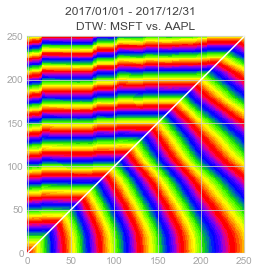

In [24]:
# Set Seaborn style for plots:
sns.set_style("whitegrid", {'font_scale':0.5,
                           'font.scale':0.5,
                           'xtick.color':'#A5A5A5',
                           'ytick.color':'#A5A5A5',
                           'axes.linewidth': 0.2,
                           'axes.facecolor': '#AEAEAE',
                           'text.color': '#424242',
                           'legend.frameon': True})

plt.title('DTW: %s vs. %s' % (x_tick, y_tick))# The 2 symbols being compared.
plt.suptitle("%s - %s" %(start.strftime("%Y/%m/%d"), end.strftime("%Y/%m/%d"))) # Show start/end dates.
# acc.T is the accumulated cost matrix returned from the dtw( ) function.
# origin is which part of the chart to start the plot.
# cmap is shorthand for color map. The 'prism' palette is particularly useful for visualizing DTW outputs.
plt.imshow(acc.T, origin='lower', cmap='prism', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

plt.show()
plt.clf() # Clear the current figure in-case we want to generate or try a different plot.

The 250 x 250 grid is the number of steps in the time series. In this case, we took 1 year of market data, hence the 250 days.

### Sanity Check
Looking at the graph, it becomes clear there is some sort of divergence that happens over time between the two time series. Let's look at a regular line plot. (Since our time series are in a pandas DataFrame, it is super-easy!)

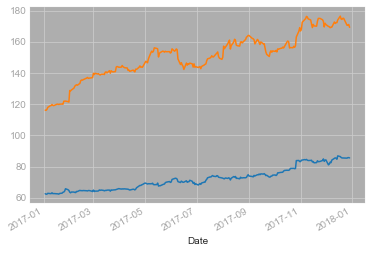

In [29]:
ts['MSFT']['Close'].plot()
ts['AAPL']['Close'].plot()

### Comparing Time Series from Different Industries
Let's compare closing prices of McDonalds and Apple. There should be some more interesting visualization results assuming there is not a tight correlation between the two series.

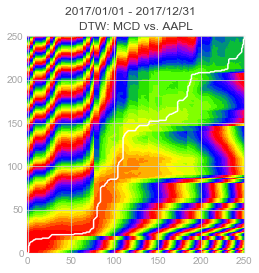

In [60]:
x_tick = 'MCD'
y_tick = 'AAPL'

# Select the time series from the Python dictionary named 'ts'.
x = np.array(ts[x_tick]['Close'])
y = np.array(ts[y_tick]['Close'])

# Reshape for number crunching.
x = array(x).reshape(-1, 1)
y = array(y).reshape(-1, 1)

# Call the DTW function:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

# Prepare the plot:
plt.title('DTW: %s vs. %s' % (x_tick, y_tick))# The 2 symbols being compared.
plt.suptitle("%s - %s" %(start.strftime("%Y/%m/%d"), end.strftime("%Y/%m/%d"))) # Show start/end dates.
plt.imshow(acc.T, origin='lower', cmap='prism', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

plt.show()
plt.clf() # Clear the current figure in-case we want to generate or try a different plot.

Wow. This is interesting. There is a lot more divergence than the MSFT vs. AAPL time series. Let's do another sanity check with a line plot:

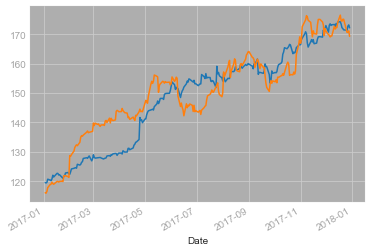

In [40]:
ts['MCD']['Close'].plot()
ts['AAPL']['Close'].plot()

The line plot shows that while one time series is experiencing market support, the other experiences market resistance, and over time there is crossover. This explains the wild, yet oddly rhythmic, visual patterns in the DTW plot.

### Time Shifting
It is also interesting to see what happens when a single time series is compared against itself. This first plot is for Deutsche Bank's closing prices, no time shifting:

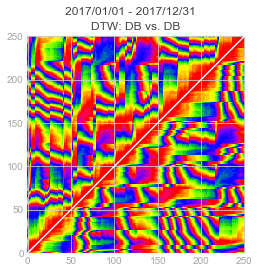

In [62]:
x_tick = 'DB'
y_tick = 'DB'

# Call the DTW function:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

# Select the time series from the Python dictionary named 'ts'.
x = np.array(ts[x_tick]['Close'])
y = np.array(ts[y_tick]['Close'])

# Reshape for number crunching.
x = array(x).reshape(-1, 1)
y = array(y).reshape(-1, 1)

# Prepare the plot:
plt.title('DTW: %s vs. %s' % (x_tick, y_tick))# The 2 symbols being compared.
plt.suptitle("%s - %s" %(start.strftime("%Y/%m/%d"), end.strftime("%Y/%m/%d"))) # Show start/end dates.
plt.imshow(acc.T, origin='lower', cmap='prism', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

plt.show()
plt.clf() # Clear the current figure in-case we want to generate or try a different plot.

Although the visuals are a bit psychedelic, there is an obvious symmetry shared between the x and y series.

#### Applying the Time Shift
Let's shift the time series and see what happens. Numpy's array slicing make it easy to do.

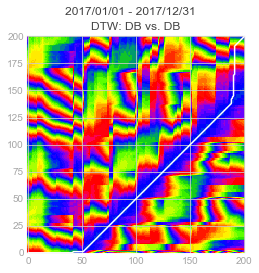

In [64]:
x_tick = 'DB'
y_tick = 'DB'

# Here is where the time series is shifted.
# The x series takes the all of the steps up to the last 50 in the series.
# The y series takes all of the steps beginning from 50 steps into the series.
# Note the comparative series is now 50 steps shorter.
x = np.array(ts[x_tick]['Close'][:-50])
y = np.array(ts[y_tick]['Close'][50:])

# Reshape for number crunching.
x = array(x).reshape(-1, 1)
y = array(y).reshape(-1, 1)

# Call the DTW function:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))

# Prepare the plot:
plt.title('DTW: %s vs. %s' % (x_tick, y_tick))# The 2 symbols being compared.
plt.suptitle("%s - %s" %(start.strftime("%Y/%m/%d"), end.strftime("%Y/%m/%d"))) # Show start/end dates.
plt.imshow(acc.T, origin='lower', cmap='prism', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

plt.show()
plt.clf() # Clear the current figure in-case we want to generate or try a different plot.

Perturbing a symmetrical set of time series results might also provide interesting insights depending on the use case.